# neuroBrite 2020 - EEG notebook

This notebook allows you to collect EEG data (using the muse system) and analyse it.

In the task you will see images of faces and buildings. Most of the faces will be adults but occasionally we will present baby faces. Most of the buildings with be houses but occasionally we will present images of castles. There are three versions of the task.

1. Count how many baby faces are presented
2. Count how many castles are presented
3. Count both faces *and* castles

EEG will be measured while participants view the images and the cells below create plots for the different versions of the task. Below you will find information on the specific EEG components we are interested in.

<!--
A couple of things are moved around and deleted:
1. Deleted step 2 (and possibly 1 if we're only running on Windows machines).
2. Deleted the 'decoding N170' portion.
3. Changed import N170 to nb2020 and the data save pathway.
4. Added subject = 1 and session = 1 to step 4 (analysis) to be able to run cells independent of step 3 (experiment).
To-dos:
5. Change introduction to involve N170 + P300/LPC: the P300 is now the N300 btw
6. Do more trials to get a good sample set. 
-->

In [1]:
# this cell loads the things we will need (make sure to run this!)
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import nb2020
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# N170

<img style="height: 300px; float: right" src="https://www.researchgate.net/profile/Vincent_Walsh3/publication/49833438/figure/fig1/AS:394279194251295@1471014893499/The-P1-and-N170-ERP-components-The-graph-shows-the-grand-average-ERP-responses-from-ten.png"/>

The N170 is a large negative event-related potential (ERP) component that occurs after the detection of faces, but not objects, scrambled faces, or other body parts such as hands. The N170 occurs around 170ms after face perception and is most easily detected at lateral posterior electrodes such as T5 and T6 [1](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.601.6917&rep=rep1&type=pdf). Frontal or profile views of human (and animal [2](https://www.ncbi.nlm.nih.gov/pubmed/14995895)) faces elicit the strongest N170 and the strength of the N170 does not seem to be influenced by how familiar a face is. Thus, although there is no consensus on the specific source of the N170, researchers believe it is related to activity in the fusiform face area, an area of the brain that shows a similar response pattern and is involved in encoding the holistic representation of a face (i.e eyes, nose mouth all arranged in the appropriate way).

In this notebook, we will attempt to detect the N170 with the Muse headband using faces and buildings as our stimuli. The Muse's temporal electrodes (TP9 and TP10) are well positioned to detect the N170 and we expect we'll be able to see an N170 emerge from just a few dozen trials. 

<!--We will then run several different classification algorithms on our data in order to evaluate the performance of a potential brain-computer interface using the N170.-->

# P300

<img style="height: 200px; float: right" src="https://ars.els-cdn.com/content/image/1-s2.0-S107158191300178X-gr2.jpg"/>

The P300 is a positive event-related potential (ERP) that occurs around 300ms after perceiving a novel or unexpected stimulus. It is most commonly elicited through 'oddball' experimental paradigms, where a certain subtype of stimulus is presented rarely amidst a background of another more common type of stimulus. Interestingly, the P300 is able to be elicited by multiple sensory modalities (e.g. visual, odditory, somatosensory). Thus, it is believed that the P300 may be a signature of higher level cognitive processing such as conscious attention.


# This Experiment

In this experiment we are measuring the N170 and P300 components at the same time!

In the experiment participants view a series of images, one at a time. To elicit an N170, around half of the images will be of human faces and the other half will be images of buildings. Comparing the EEG for faces and buildings we should find that the former result in a more negative going potential around 170 ms after the presentation of the image.

To look at the P300 we have also included some 'oddball' images. Most of the faces will be adult faces but a small percentage will be faces of babies. For images of buildings, the majority will be regular houses but a small percentage will be images of castles. These pictures of babies and castles should stand out relative to the other more frequent image types and we would expect them to elicit a P300.

But we're not just interested in seeing a N170/P300 - what we really want to do is see if we can manipulate the magnitude of these components. To do this we have three conditions, which differ in the instructions given to the participant:

1. Count how many baby faces are presented
2. Count how many castles are presented
3. Count both faces *and* castles

What do you expect to happen and why? How do you think the EEG components will differ between these three versions of the task?

## Step 1: Connect to an EEG Device

<img style="height: 300px; float: right" src="../images/bluemuse-steps.png"/>

Use the BlueMuse application to connect to the Muse device via bluetooth (make sure that the PC bluetooth is turned on)

Here are the steps to connect to the Muse:

1. Open the BlueMuse App (this should be pinned to the taskbar - see icon -->)
2. Turn on the Muse (if the Muse isn't detected or stays offline, press the refresh button)
3. Once online, click 'Start Streaming'
4. These windows should appear -->. You're now streaming EEG and can move to the next step

<!---
*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*
Make sure your Muse 2016 is turned on and then run the following code. It should detect and connect to the device and begin 'Streaming...'
If the device is not found or the connection times out, try running this code again
# Search for available Muse devices
muses = list_muses()
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()
--->

## Step 2: View the EEG Signal and Wait for Signal Quality to Stabilize

Once your Muse is connected and streaming data, put it on and run the following code in a new Anaconda window to view the raw EEG data stream.

```
conda activate neurobrite
muselsl view -v2
```

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

### Things to try to improve signal quality

[This video](https://www.youtube.com/watch?v=rj322IItuFg) shows you some techniques for improving signal quality. Here are some of the main things you an try:

* Extend the headband all the way (to the largest setting) then adjust around your head
* Ensure the front of the headband is in the middle of your forehead and the front sensors are touching the skin
* Make sure the ear sensors surround the ears (like glasses). Remove any hair that might be in the way
* Once fitted, sit still and relax trying not to move too much (particularly your jaw). Wait around 20 seconds to see if the signal stabilizes
* If the signal quality does not improve, try wiping the sensors with a damp cloth or paper towel

## Step 3: Run the Experiment

*Here is where you select the version of the experiment you want to complete*
<!--Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are collecting data from.-->

In [3]:
# Set this
version = 1 # 1 = count babies, 2 = count castles, 3 = count babies and castles

# you can leave these
duration = 120 # in seconds. 120 is recommended
subject = 1 # unique id for each participant

Seat the subject in front of the computer and run the following cell to complete a single run of the experiment.

In order to maximise the possibility of success, participants should take the experiment in a quiet environment and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should focus on the stimuli.

Data will be recorded into CSV files in the `eeg-notebooks/data/visual/nb2020/` directory

In [ ]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "nb2020", "subject" + 
                              str(subject), "session" + str(version), ("recording_%s.csv" % strftime("%Y-%m-%d-%H.%M.%S", gmtime())))

print('Recording data to: ', recording_path)

stimulus = Process(target=nb2020.present, args=(duration,version))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

### Repeat Data Collection 3-6 times

Visualizing ERPs requires averaging the EEG response over many different rounds of stimulus presentation. Depending on experimental conditions, this may require as little as one two minute trial or as many as 6. We recommend repeating the above experiment at least 3 times before proceeding. 

Make sure to take breaks, though! Inattention, fatigue, and distraction will decrease the quality of event-related potentials such as the N170.

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the N170.


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object.

*Note that below we have to set which version of the task we are interested in seeing data from*

In [2]:
version = 3 # change this to look at data from different versions of the experiment

subject = 1 # this can be left as is

raw = utils.load_data('visual/nb2020', sfreq=256., 
                      subject_nb=subject, session_nb=version) # the data for different versions of the experiment is stored in different session files within each subjects' folder (i.e., session1 == version1): data can be found in eeg-notebooks/data/visual/nb2020/


Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30576
    Range : 0 ... 30575 =      0.000 ...   119.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30588
    Range : 0 ... 30587 =      0.000 ...   119.480 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30576
    Range : 0 ... 30575 =      0.000 ...   119.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30576
    Range : 0 ... 30575 =      0.000 ...   119.434 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ..

### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the N170 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes.



Effective window size : 8.000 (s)


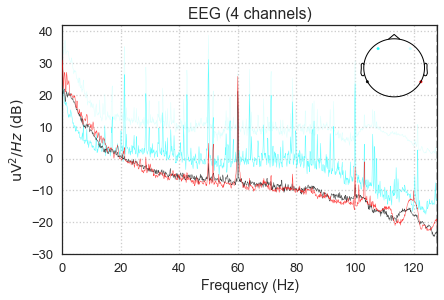

In [3]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a large peak at 60hz, representing background electrical activity.

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


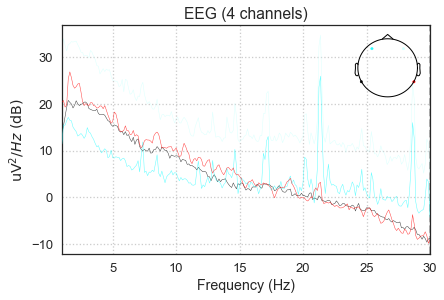

In [4]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD of frequencies between 1 and 30 hz looks good. The difference between the temporal channels (red and black) and the frontal channels (blue and green) is clearly evident. The huge peak from 1 to 3hz is largely due to the presence of eye blinks, which produce large amplitude, low-frequency events in the EEG.

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [5]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'Face': 1, 'Baby': 2, 'House': 3, 'Castle': 4}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - float(len(epochs.events))/float(len(events))) * 100)
epochs

1119 events found
Event IDs: [1 2 3 4]
sample drop %:  36.639857015192135


<Epochs  |   709 events (all good), -0.101562 - 0.800781 sec, baseline off, ~5.0 MB, data loaded,
 'Baby': 57
 'Castle': 58
 'Face': 288
 'House': 306>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data.

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP and compare different conditions

### Frequent vs. Infrequent

The plot below shows the waveforms for the frequent stimuli (adult faces and houses) and infrequent stimuli (baby faces and castles). Do you see any differences?

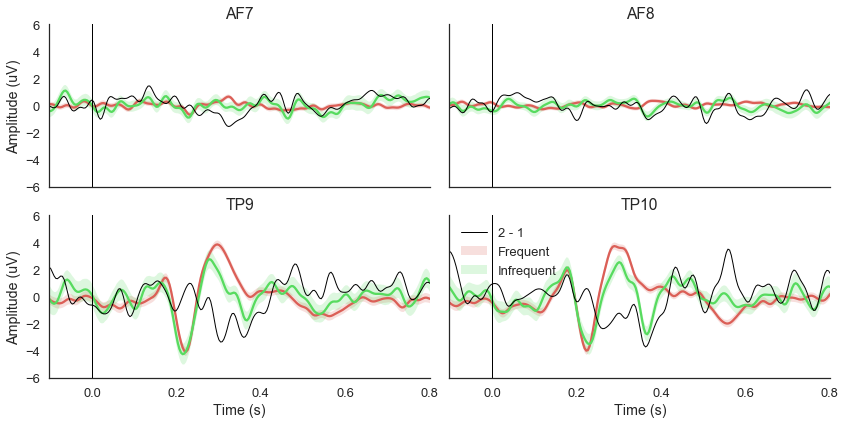

In [6]:
%matplotlib inline
conditions = OrderedDict()
conditions['Frequent'] = [1, 3]
conditions['Infrequent'] = [2, 4]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=68, n_boot=1000, title='',
                                diff_waveform=(1, 2))

### Face vs. Building

The plot below compares faces (adult and baby) with buildings (houses and buildings)

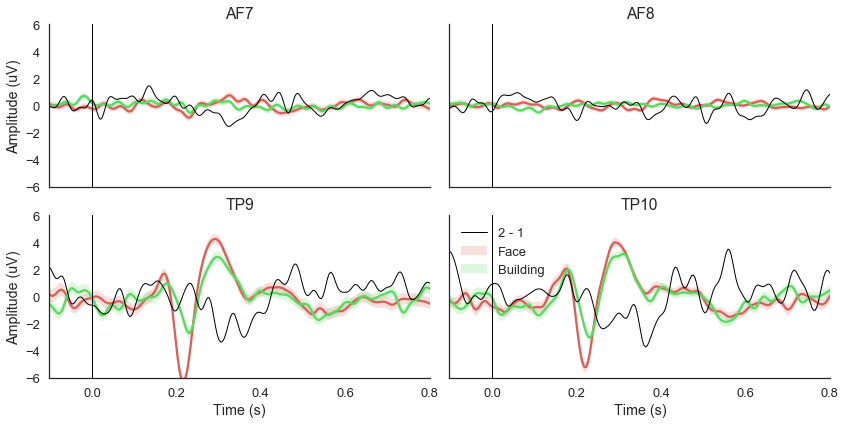

In [7]:
%matplotlib inline
conditions = OrderedDict()
conditions['Face'] = [1, 2]
conditions['Building'] = [3, 4]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=68, n_boot=1000, title='',
                                diff_waveform=(1, 2))

### Faces: adult vs. baby

The plot below shows the waveforms for the two kinds of face stimuli.

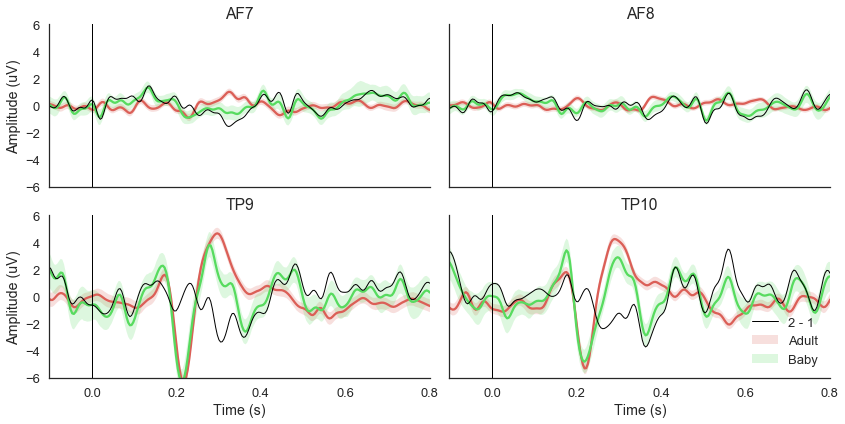

In [8]:
%matplotlib inline
conditions = OrderedDict()
conditions['Adult'] = [1]
conditions['Baby'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=68, n_boot=1000, title='',
                                diff_waveform=(1, 2))

### Buildings: houses vs. castles

The plot below shows the waveforms for the two kinds of building stimuli.

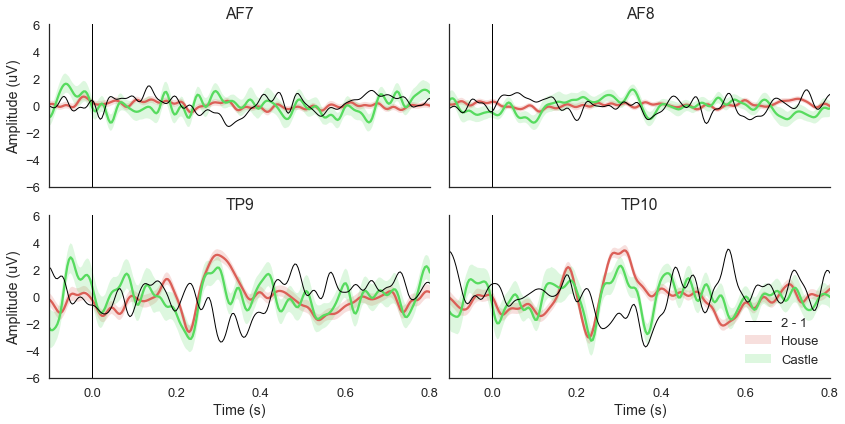

In [9]:
%matplotlib inline
conditions = OrderedDict()
conditions['House'] = [3]
conditions['Castle'] = [4]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=68, n_boot=1000, title='',
                                diff_waveform=(1, 2))